In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
import torch
from utils import ood_scatter_plot, recon_var_plot, populate_layer_stats, comparative_mean_plot, comparative_var_plot, img_stat, disentangled_mean_plot
import danns_eg.densenet as densenets
import pickle

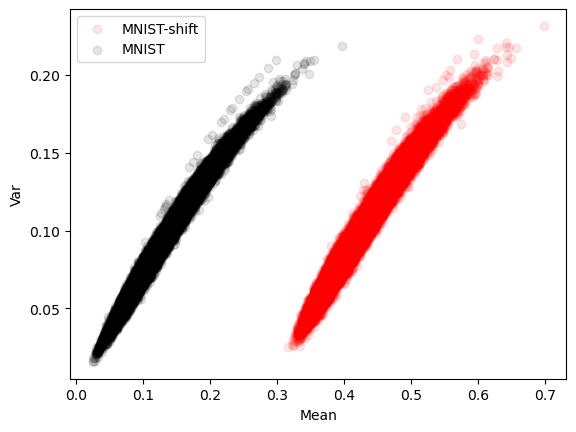

In [2]:
img_stat()

range(0, 50)


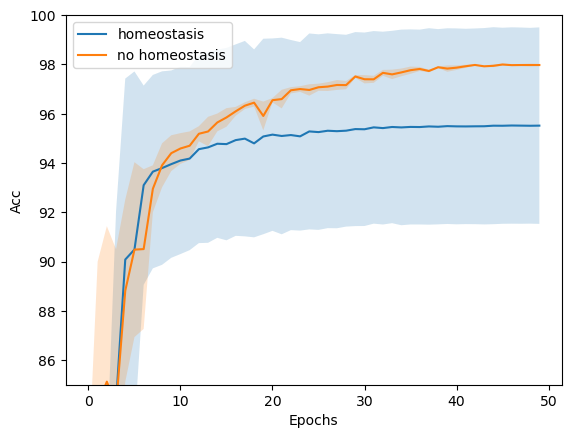

In [23]:
n = 5

homeo_arr = np.array([[]])
non_homeo_arr = np.array([[]])

for i in range(n):

    if i==3:
        continue

    # Specify the file name
    file_name_homeo = f'res/homeo_dann_{i}_results.pkl'
    file_name_no_homeo = f'res/non_homeo_dann_{i}_results.pkl'

    # Open the file in binary read mode ('rb')
    with open(file_name_homeo, 'rb') as file:
        # Use pickle.load() to load the list from the file
        homeo = pickle.load(file)

    # Open the file in binary read mode ('rb')
    with open(file_name_no_homeo, 'rb') as file:
        # Use pickle.load() to load the list from the file
        no_homeo = pickle.load(file)

    if i == 0:
        homeo_arr = np.array([homeo["test_accs"]])
        non_homeo_arr = np.array([no_homeo["test_accs"]])
    else:
        homeo_arr = np.append(homeo_arr, [np.array(homeo["test_accs"])], axis=0)
        non_homeo_arr = np.append(non_homeo_arr, [np.array(no_homeo["test_accs"])], axis=0)

h = homeo_arr.mean(axis=0)
n_h = non_homeo_arr.mean(axis=0)
plt.plot(homeo_arr.mean(axis=0), label="homeostasis")
plt.fill_between(range(len(h)), h - homeo_arr.std(axis=0), h + homeo_arr.std(axis=0), alpha=0.2)
plt.plot(non_homeo_arr.mean(axis=0), label="no homeostasis")
plt.fill_between(range(len(n_h)), n_h - non_homeo_arr.std(axis=0), n_h + non_homeo_arr.std(axis=0), alpha=0.2)
plt.ylim(85, 100)
print(range(len(n_h)))
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.legend()

In [19]:
# Specify the file name
file_name_homeo = 'res/homeo_dann_0_layers.pkl'
file_name_no_homeo = 'res/non_homeo_dann_0_layers.pkl'

# Open the file in binary read mode ('rb')
with open(file_name_homeo, 'rb') as file:
    # Use pickle.load() to load the list from the file
    homeo = pickle.load(file)

# Open the file in binary read mode ('rb')
with open(file_name_no_homeo, 'rb') as file:
    # Use pickle.load() to load the list from the file
    no_homeo = pickle.load(file)

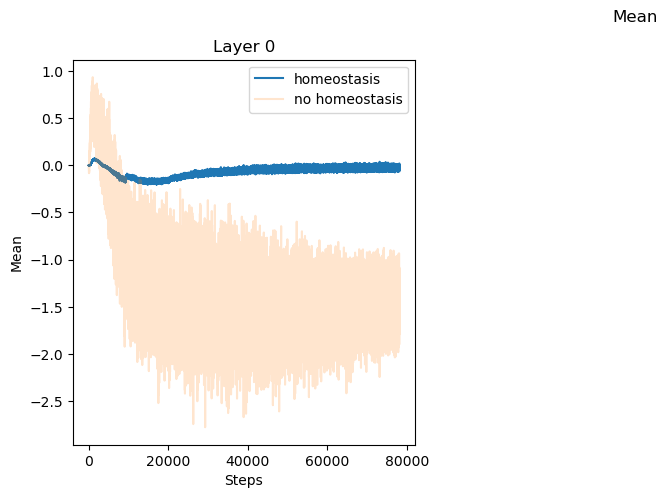

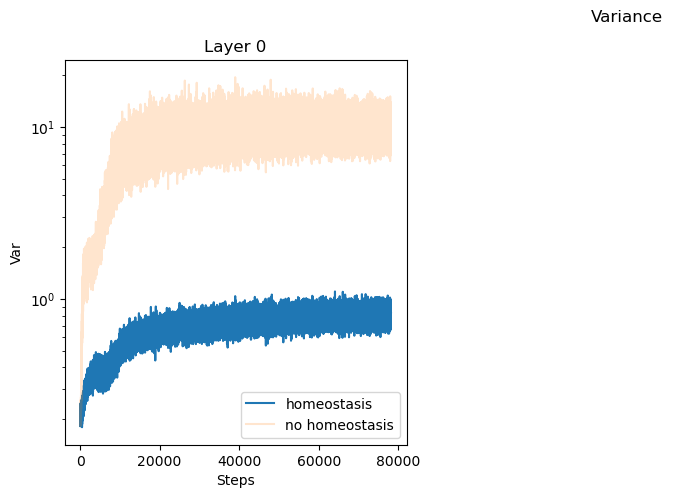

In [20]:
comparative_mean_plot(homeo, no_homeo, label1="homeostasis", label2="no homeostasis")
comparative_var_plot(homeo, no_homeo, label1="homeostasis", label2="no homeostasis")

In [2]:
homeo_acc = np.array([[]])
non_homeo_acc = np.array([[]])
for idxx in range(5):
    homeo_model_state_dict = torch.load(f'res/homeo_dann_{idxx}.pt')
    non_homeo_model_state_dict = torch.load(f'res/non_homeo_dann_{idxx}.pt')
    input_dim = 784
    num_class = 10
    width=500
    model_homeo = densenets.DenseDANN(input_dim, width, num_class, homeostasis=True)
    model_homeo.load_state_dict(homeo_model_state_dict)
    model_non_homeo = densenets.DenseDANN(input_dim, width, num_class, homeostasis=False)
    model_non_homeo.load_state_dict(non_homeo_model_state_dict)
    x_acc_noise, _, _, homeo_ac = disentangled_mean_plot(model_homeo.cuda(), var_pert=False, inhibitory=True, return_acc=True, max_noise=0.1)
    x_acc_noise, _, _, non_homeo_ac = disentangled_mean_plot(model_non_homeo.cuda(), var_pert=False, inhibitory=True, return_acc=True, max_noise=0.1)

    if idxx == 0:
        homeo_acc = np.array([homeo_ac])
        non_homeo_acc = np.array([non_homeo_ac])
    else:
        homeo_acc = np.append(homeo_acc, [np.array(homeo_ac)], axis=0)
        non_homeo_acc = np.append(non_homeo_acc, [np.array(non_homeo_ac)], axis=0)

h_acc = homeo_acc.mean(axis=0)
n_h_acc = non_homeo_acc.mean(axis=0)

Homeostasis is True
Homeostasis is False
Homeostasis is True
Homeostasis is False
Homeostasis is True
Homeostasis is False
Homeostasis is True
Homeostasis is False
Homeostasis is True
Homeostasis is False


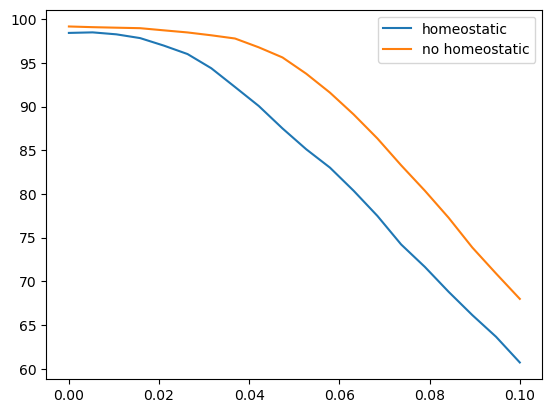

In [3]:
plt.plot(x_acc_noise, h_acc, label="homeostatic")
plt.plot(x_acc_noise, n_h_acc, label="no homeostatic")
plt.legend()

In [2]:
homeo_model_state_dict = torch.load('res/homeo_dann_2.pt')
non_homeo_model_state_dict = torch.load('res/non_homeo_dann_2.pt')
input_dim = 784
num_class = 10
width=500
model_homeo = densenets.DenseDANN(input_dim, width, num_class, homeostasis=True)
model_homeo.load_state_dict(homeo_model_state_dict)
model_non_homeo = densenets.DenseDANN(input_dim, width, num_class, homeostasis=False)
model_non_homeo.load_state_dict(non_homeo_model_state_dict)

Homeostasis is True
Homeostasis is False


<All keys matched successfully>

In [15]:
# Average this over a couple runs
def mean_shift_sec_moment(ax, add_no_homeo=True):
    variance_perturbation = False
    x, mu, inh_homeo_var= disentangled_mean_plot(model_homeo.cuda(), var_pert=variance_perturbation, inhibitory=True)
    #ax.plot(x, inh_homeo_var, linestyle='--', color='blue')
    x, mu, inh_no_homeo_var= disentangled_mean_plot(model_non_homeo.cuda(), var_pert=variance_perturbation, inhibitory=True)
    #ax.plot(x, inh_no_homeo_var,  linestyle='--', color='orange')
    x, mu, exc_homeo_var= disentangled_mean_plot(model_homeo.cuda(), var_pert=variance_perturbation, inhibitory=False)
    #ax.plot(x, exc_homeo_var, label="Homeostasis E(-) / I (--)", linestyle='-', color='blue')
    x, mu, exc_no_homeo_var= disentangled_mean_plot(model_non_homeo.cuda(), var_pert=variance_perturbation, inhibitory=False)
    #ax.plot(x, exc_no_homeo_var, label="No Homeostasis E(-) / I (--)", linestyle='-', color='orange')
    if add_no_homeo:
        ax.plot(x, inh_no_homeo_var/exc_no_homeo_var, label="No Homeostasic I/E Ratio", linestyle='--', color='black')
    ax.plot(x, inh_homeo_var/exc_homeo_var, label="Homeostasic I/E Ratio", linestyle='-', color='black')
    #ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel("Variance Shift" if variance_perturbation else "Mean Shift")
    ax.set_ylabel("Layer Second Moment")

In [20]:
def mean_shift_mean(ax, add_no_homeo=True):
    # Average this over a couple runs
    variance_perturbation = False
    x, inh_homeo_mu, var= disentangled_mean_plot(model_homeo.cuda(), var_pert=variance_perturbation, inhibitory=True)
    #ax.plot(x, mu, linestyle='--', color='blue')
    x, inh_no_homeo_mu, var= disentangled_mean_plot(model_non_homeo.cuda(), var_pert=variance_perturbation, inhibitory=True)
    #ax.plot(x, mu,  linestyle='--', color='orange')
    x, exc_homeo_mu, var= disentangled_mean_plot(model_homeo.cuda(), var_pert=variance_perturbation, inhibitory=False)
    #ax.plot(x, mu, label="Homeostasis E(-) / I (--)", linestyle='-', color='blue')
    x, exc_no_homeo_mu, var= disentangled_mean_plot(model_non_homeo.cuda(), var_pert=variance_perturbation, inhibitory=False)
    #ax.plot(x, mu, label="No Homeostasis E(-) / I (--)", linestyle='-', color='orange')
    if add_no_homeo:
        ax.plot(x, np.abs(inh_no_homeo_mu/exc_no_homeo_mu), label="No Homeostasic I/E Ratio", linestyle='--', color='black')
    ax.plot(x, np.abs(inh_homeo_mu/exc_homeo_mu), label="Homeostasic I/E Ratio", linestyle='-', color='black')
    ax.legend()
    ax.set_xlabel("Variance Shift" if variance_perturbation else "Mean Shift")
    ax.set_ylabel("Layer Mean")

In [8]:
def load_mnist():
    mnist = fetch_openml('Fashion-MNIST', version=1, cache=True)
    return mnist.data.to_numpy().astype('float32') / 255.0, mnist.target.to_numpy().astype('int')



In [9]:
def precompute_principal_components(data, max_components):
    pca = PCA(n_components=max_components)
    pca.fit(data)
    return pca.components_

In [10]:
def reconstruct_image_with_components(image, components):
    # Flatten the image into a 1D array
    flattened_image = image.reshape(-1, image.shape[-1])

    # Transform the flattened image into the PCA space using precomputed components
    transformed_image = np.dot(flattened_image, components.T)

    # Reconstruct the image from the PCA space using all components
    reconstructed_flattened_image = np.dot(transformed_image, components)

    # Reshape the reconstructed image back to its original shape
    reconstructed_image = reconstructed_flattened_image.reshape(image.shape)

    return reconstructed_image

In [11]:
def plot_images(images, title):
    plt.figure(figsize=(10, 2))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()



In [12]:
# Load MNIST data
X, y = load_mnist()

In [13]:
components = precompute_principal_components(X, max_components=784)

In [ ]:
# Choose an image index to reconstruct
image_index = 1090
original_image = X[image_index]

for n_components in range(1, 200,10):
    reconstructed_image = reconstruct_image_with_components(original_image, components[:n_components])

    # Plot original and reconstructed images
    plot_images([original_image, reconstructed_image], f"Components: {n_components}")

In [17]:
# Specify the file name
file_name_mnist_test_homeo = f'res/homeo_dann_0__meanvar_layers_mnist_test.pkl'
file_name_mnist_train_homeo = f'res/homeo_dann_0__meanvar_layers_mnist_train.pkl'
file_name_mnist_test_no_homeo = f'res/non_homeo_dann_0__meanvar_layers_mnist_test.pkl'
file_name_mnist_train_no_homeo = f'res/non_homeo_dann_0__meanvar_layers_mnist_train.pkl'

# Open the file in binary read mode ('rb')
with open(file_name_mnist_test_homeo, 'rb') as file:
    # Use pickle.load() to load the list from the file
    homeo_test = pickle.load(file)

# Open the file in binary read mode ('rb')
with open(file_name_mnist_train_homeo, 'rb') as file:
    # Use pickle.load() to load the list from the file
    homeo_train = pickle.load(file)

# Open the file in binary read mode ('rb')
with open(file_name_mnist_train_no_homeo, 'rb') as file:
    # Use pickle.load() to load the list from the file
    no_homeo_train = pickle.load(file)

# Open the file in binary read mode ('rb')
with open(file_name_mnist_test_no_homeo, 'rb') as file:
    # Use pickle.load() to load the list from the file
    no_homeo_test = pickle.load(file)

In [18]:
homeo_mean_test = homeo_test[0][:,0]
homeo_var_test = homeo_test[0][:,1]
homeo_mean_train = homeo_train[0][:,0]
homeo_var_train = homeo_train[0][:,1]
no_homeo_mean_test = no_homeo_test[0][:,0]
no_homeo_var_test = no_homeo_test[0][:,1]
no_homeo_mean_train = no_homeo_train[0][:,0]
no_homeo_var_train = no_homeo_train[0][:,1]
data = [homeo_mean_train, homeo_mean_test, homeo_var_train, homeo_var_test,
        no_homeo_mean_train, no_homeo_mean_test, no_homeo_var_train, no_homeo_var_test]
data_mean = [homeo_mean_train, no_homeo_mean_train]
data_var = [homeo_var_train, no_homeo_var_train]
data_idd = [homeo_mean_train, homeo_mean_test, homeo_var_train, homeo_var_test]

/tmp/ipykernel_1634178/1926297381.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['homeostasis', 'no homeostasis'])


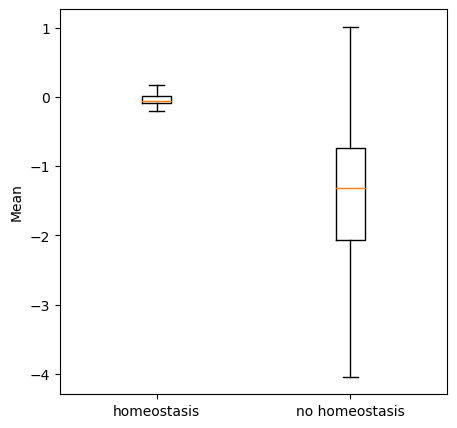

In [5]:
fig = plt.figure(figsize =(5, 5))
 
# Creating axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['homeostasis', 'no homeostasis'])
ax.set_ylabel('Mean')
# Creating plot
bp = ax.boxplot(data_mean, showfliers=False)

/tmp/ipykernel_1634178/952199986.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['homeostasis', 'no homeostasis'])


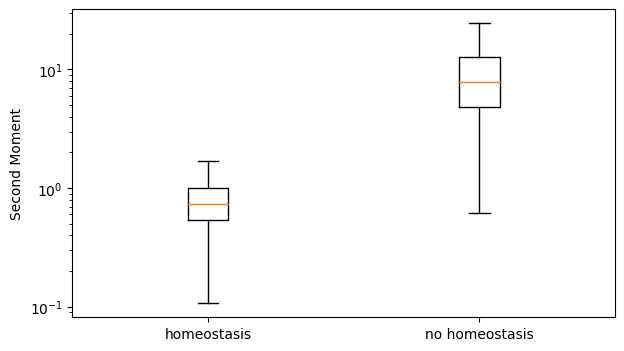

In [6]:
fig = plt.figure(figsize=(7,4))
 
# Creating axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['homeostasis', 'no homeostasis'])
ax.set_ylabel('Second Moment')
ax.set_yscale('log')
# Creating plot
bp = ax.boxplot(data_var, showfliers=False)

/tmp/ipykernel_753662/1384291116.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['homeostasis', 'no homeostasis'])
/tmp/ipykernel_753662/1384291116.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['homeostasis', 'no homeostasis'])


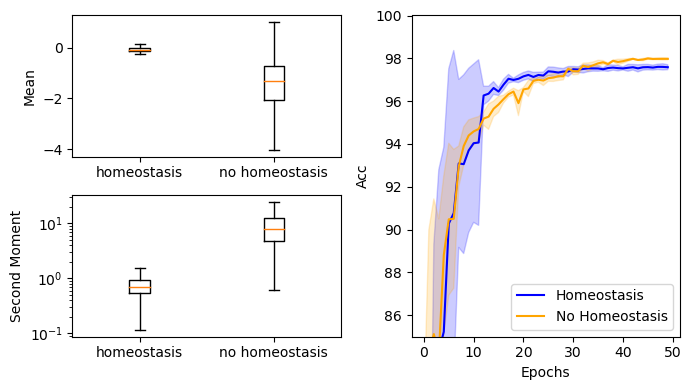

In [19]:
plt.close('all')
plt.figure(figsize=(7,4))

ax1 = plt.subplot(221)
ax2 = plt.subplot(223)
ax3 = plt.subplot(122)


ax1.set_xticklabels(['homeostasis', 'no homeostasis'])
ax1.set_ylabel('Mean')
# Creating plot
ax1.boxplot(data_mean, showfliers=False)

ax2.set_xticklabels(['homeostasis', 'no homeostasis'])
ax2.set_ylabel('Second Moment')
ax2.set_yscale('log')
# Creating plot
ax2.boxplot(data_var, showfliers=False)


ax3.plot(homeo_arr.mean(axis=0), label="Homeostasis", color='blue')
ax3.fill_between(range(len(h)), h - homeo_arr.std(axis=0), h + homeo_arr.std(axis=0), alpha=0.2, color='blue')
ax3.plot(non_homeo_arr.mean(axis=0), label="No Homeostasis", color='orange')
ax3.fill_between(range(len(n_h)), n_h - non_homeo_arr.std(axis=0), n_h + non_homeo_arr.std(axis=0), alpha=0.2, color='orange')
ax3.set_ylim(85, 100)
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Acc")
ax3.legend(loc='lower right')

plt.tight_layout()

In [ ]:
plt.close('all')
plt.figure(figsize=(7,4))

ax1 = plt.subplot2grid((3, 3), (0, 0))
# ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
ax3 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4 = plt.subplot2grid((3, 3), (1, 2), colspan=1, rowspan=2)

img_stat(ax1)
mean_shift_sec_moment(ax3)


ax2.plot(x_acc_noise, h_acc, label="homeostatic")
ax2.plot(x_acc_noise, n_h_acc, label="no homeostatic")
ax2.set_ylabel("Acc")
ax2.set_xlabel("Mean Shift")
ax2.legend()


mean_shift_mean(ax4)



plt.tight_layout()

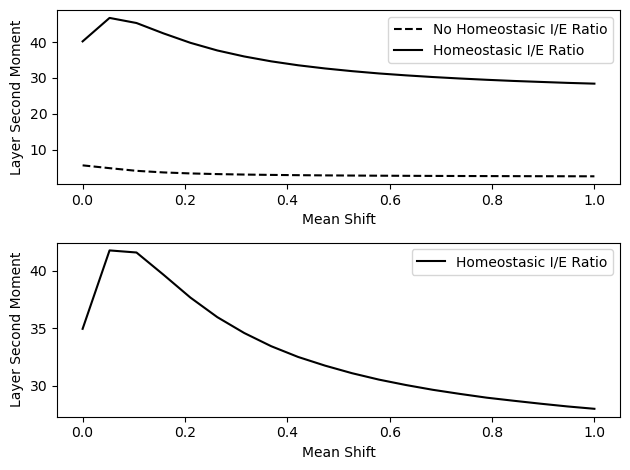

In [21]:
import matplotlib.gridspec as gridspec

plt.close('all')
fig = plt.figure()

gs1 = gridspec.GridSpec(2, 1)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

mean_shift_sec_moment(ax1)
mean_shift_sec_moment(ax2, add_no_homeo=False)

gs1.tight_layout(fig)

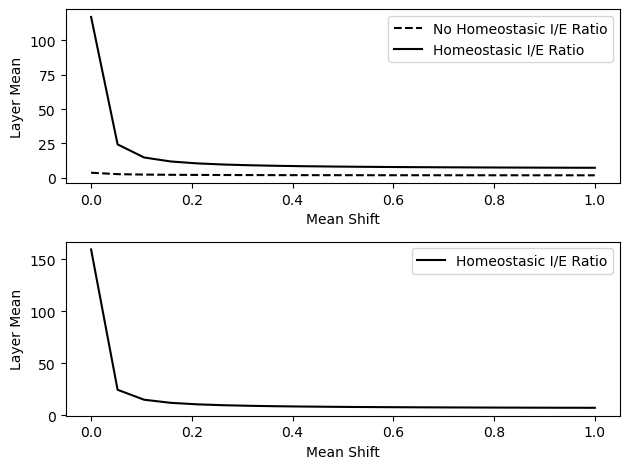

In [22]:
import matplotlib.gridspec as gridspec

plt.close('all')
fig = plt.figure()

gs1 = gridspec.GridSpec(2, 1)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

mean_shift_mean(ax1)
mean_shift_mean(ax2, add_no_homeo=False)

gs1.tight_layout(fig)

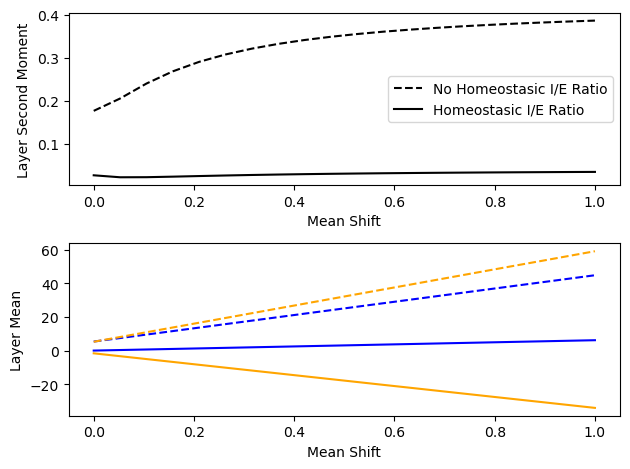

In [10]:
import matplotlib.gridspec as gridspec

plt.close('all')
fig = plt.figure()

gs1 = gridspec.GridSpec(2, 1)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

mean_shift_sec_moment(ax1)
mean_shift_mean(ax2)

gs1.tight_layout(fig)

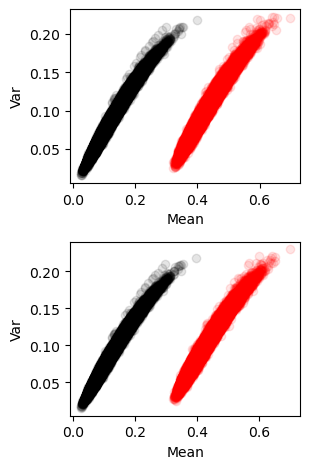

In [17]:
fig = plt.figure()

gs1 = gridspec.GridSpec(2, 1)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

img_stat(ax1)
img_stat(ax2)

gs1.tight_layout(fig, rect=[0, 0, 0.5, 1.0])

In [8]:
from matplotlib import font_manager
from pathlib import Path

# Add arial font to the font manager
font_dirs = ['.']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
print(font_files)
if len(font_files) == 0:
    print("No fonts found")
else:
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)

        if Path(font_file).name == "arial.ttf":
            plt.rcParams['font.family'] = 'Arial'

['/home/mila/r/roy.eyono/danns_eg/dense_mnist_task/Arial.ttf']


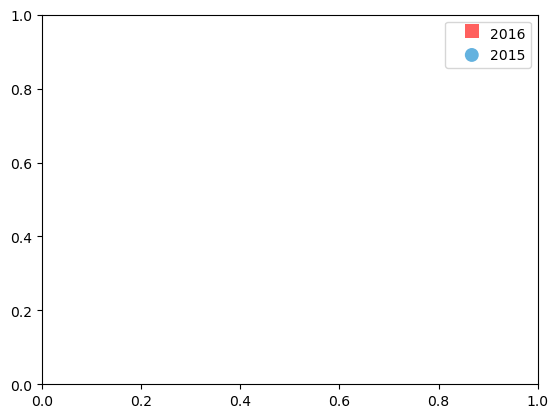

In [9]:
# Customising legend
# https://stackoverflow.com/questions/40672088/matplotlib-customize-the-legend-to-show-squares-instead-of-rectangles
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerPatch

# --- handlers ---

class HandlerRect(HandlerPatch):

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):

        x = width//2
        y = 0
        w = h = 10

        # create
        p = patches.Rectangle(xy=(x, y), width=w, height=h)

        # update with data from oryginal object
        self.update_prop(p, orig_handle, legend)

        # move xy to legend
        p.set_transform(trans)

        return [p]

class HandlerCircle(HandlerPatch):

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):

        r = 5
        x = r + width//2
        y = height//2

        # create 
        p = patches.Circle(xy=(x, y), radius=r)

        # update with data from oryginal object
        self.update_prop(p, orig_handle, legend)

        # move xy to legend
        p.set_transform(trans)

        return [p]

# --- main ---

rect = patches.Rectangle((0,0), 1, 1, facecolor='#FF605E')
circ = patches.Circle((0,0), 1, facecolor='#64B2DF')

leg_handler_map={
               patches.Rectangle: HandlerRect(),
               patches.Circle: HandlerCircle(),
            }
plt.legend((rect, circ), ('2016', '2015'),
            handler_map=leg_handler_map)

plt.show()

In [11]:
import matplotlib
# this changes but for those plots I did this
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
matplotlib.rc('axes', labelsize=14)